In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from datasets import load_titanic, balance_classes
from tools import *
import pandas as pd
import numpy as np
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import plotly.express as px
from sklearn.metrics import classification_report, plot_roc_curve


In [2]:
df, df_train, df_test = load_titanic()
df_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'target'], dtype='object')

In [3]:
original_X = df.drop(['target'], axis=1)
original_y = df['target']
train_X = df_train.drop(['target'], axis=1)
train_y = df_train['target']
test_X = df_test.drop(['target'], axis=1)
test_y = df_test['target']

In [4]:
original_X = pd.get_dummies(original_X)
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

features = train_X.columns

In [5]:
scaler = StandardScaler().fit(original_X)
original_X = scaler.transform(original_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

original_X = pd.DataFrame(original_X, columns=features)
train_X = pd.DataFrame(train_X, columns=features)
test_X = pd.DataFrame(test_X, columns=features)

## Forward selection

In [6]:
model = LogisticRegression(penalty='none')

In [7]:
scores = []

for i in range(1,len(features)):
    selection_forward = SequentialFeatureSelector(model, n_features_to_select=i, direction='forward').fit(original_X, original_y)

    selected_features = train_X.columns[selection_forward.get_support()]
    scores.append(cross_val_score(model, original_X[selected_features], original_y, cv=10).mean())

result = pd.DataFrame(zip(range(1, len(features)), scores), columns=['n of features', 'accuracy (mean)'])
px.line(result, x='n of features', y='accuracy (mean)')

In [8]:
selection_forward = SequentialFeatureSelector(model, n_features_to_select=3, direction='forward').fit(original_X, original_y)

In [9]:
# to je zajimave, dle koeficientu sibsp ani patch neni tak podstatne
selected_features = features[selection_forward.get_support()]
selected_features

Index(['pclass', 'sibsp', 'sex_female'], dtype='object')

In [10]:
# stratified (balanced), 5-fold
cross_val_score(model, original_X[selected_features], original_y).mean()

0.7990898248697508

In [11]:
model = model.fit(train_X[selected_features], train_y)

In [12]:
model.classes_

array([0, 1])

In [13]:
model_performance(model, train_X[selected_features], train_y, test_X[selected_features], test_y)

Train score
0.8009630818619583
Test score
0.7985074626865671


In [14]:
confusion_matrix(model.predict(train_X[selected_features]), train_y, model.predict(test_X[selected_features]), test_y)

Train
TN: 337, TP: 162, FN: 77, FP: 47
Test
TN: 146, TP: 68, FN: 35, FP: 19


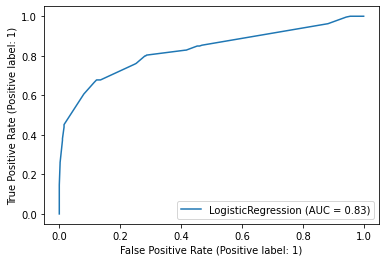

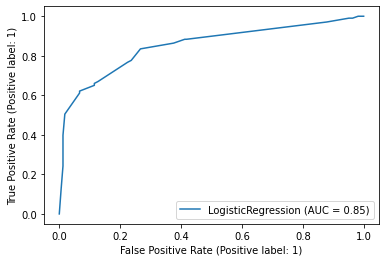

In [15]:
plot_roc_curve(model, train_X[selected_features], train_y)
plot_roc_curve(model, test_X[selected_features], test_y)

In [16]:
pd.DataFrame(zip(model.coef_[0], selected_features), columns=['coef', 'features'])

,coef,features
0,-0.722282,pclass
1,-0.330610,sibsp
2,1.308479,sex_female


## Backward selection

In [42]:
scores = []

for i in range(1,len(features)):
    selection_forward = SequentialFeatureSelector(model, n_features_to_select=i, direction='backward').fit(original_X, original_y)

    selected_features = train_X.columns[selection_forward.get_support()]
    scores.append(cross_val_score(model, original_X[selected_features], original_y, cv=10).mean())

result = pd.DataFrame(zip(range(1, len(features)), scores), columns=['n of features', 'accuracy (mean)'])
px.line(result, x='n of features', y='accuracy (mean)')

In [43]:
selection_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction='backward').fit(original_X, original_y)

In [44]:
# uplne jiny vysledek
selected_features = features[selection_backward.get_support()]
selected_features

Index(['pclass', 'age', 'sibsp', 'sex_male', 'embarked_S'], dtype='object')

In [45]:
# stratified (balanced), 5-fold
cross_val_score(LogisticRegression(), original_X[selected_features], original_y).mean()

0.7946142740568704

In [46]:
model = model.fit(train_X[selected_features], train_y)

In [47]:
model_performance(model, train_X[selected_features], train_y, test_X[selected_features], test_y)

Train score
0.8033707865168539
Test score
0.8022440392706872


In [48]:
confusion_matrix(model.predict(train_X[selected_features]), train_y, model.predict(test_X[selected_features]), test_y)

Train
TN: 98, TP: 45, FN: 23, FP: 12
Test
TN: 375, TP: 197, FN: 77, FP: 64


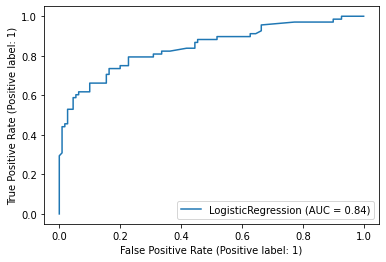

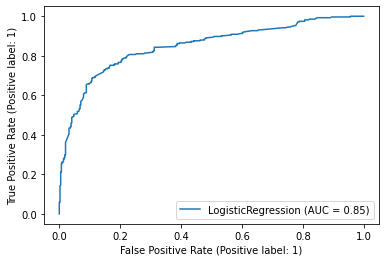

In [49]:
plot_roc_curve(model, train_X[selected_features], train_y)
plot_roc_curve(model, test_X[selected_features], test_y)